# Evo 2 Mech Interp Example Notebook
### 25.06.05

Minimal example of extracting features for an *E. coli* genome chunk and plotting to recreate parts of the main and supplementary figures

In [1]:
# !pip install matplotlib

In [2]:
from typing import List, Optional, Callable

import torch

from Bio import SeqIO

import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from tqdm.notebook import tqdm

from evo2 import Evo2


# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.set_grad_enabled(False)

import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

[10/02/25 19:23:13] WARNING  transformer_engine.pytorch.attention.dot_product_attention.utils -      ]8;id=156587;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/transformer_engine/pytorch/attention/dot_product_attention/backends.py\backends.py]8;;\:]8;id=264519;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/transformer_engine/pytorch/attention/dot_product_attention/backends.py#98\98]8;;\
                             WARNING - Supported flash-attn versions are >= 2.1.1, <= 2.7.4.post1.                 
                             Found flash-attn 2.8.0.post2.                                                         

## Load SAE

In [3]:
class ModelScope:
    """Class for adding, using, and removing PyTorch hooks with a model."""

    def __init__(self, model):
        self.model = model
        self.hooks = {}
        self.activations_cache = {}
        self.override_store = {}
        self._build_module_dict()

    """Module listing."""
    def _build_module_dict(self):
        """Walks the model's module tree and builds a name: module map."""
        self._module_dict = {}

        def recurse(module, prefix=''):
            """Recursive tree walk to build self._module_dict."""
            for name, child in module.named_children():
                self._module_dict[prefix+name] = child
                recurse(child, prefix=prefix+name+'-')

        recurse(self.model)  # build the tree

    def list_modules(self):
        """Lists all modules in the module dictionary."""
        return self._module_dict.keys()
    
    """Generic hook registration"""
    def add_hook(self, hook_fn, module_str, hook_name):
        """Add a hook_fn to the module given by module_str."""
        module = self._module_dict[module_str]
        hook_handle = module.register_forward_hook(hook_fn)
        self.hooks[hook_name] = hook_handle
    
    """Activations caching"""
    def _build_caching_hook(self, module_str):
        self.activations_cache[module_str] = []
        def hook_fn(model, input, output):
            self.activations_cache[module_str].append(output)

        return hook_fn

    def add_caching_hook(self, module_str):
        """Adds an activations caching hook at the location in module_str."""
        hook_fn = self._build_caching_hook(module_str)
        self.add_hook(hook_fn, module_str, 'cache-'+module_str)

    def clear_cache(self, module_str):
        """Clears the activations cache corresponding to module_str."""
        if module_str not in self.activations_cache.keys():
            raise KeyError(f'No activations cache for {module_str}.')
        
        else:
            self.activations_cache[module_str] = []

    def clear_all_caches(self):
        """Clear all activation caches."""
        for module_str in self.activations_cache.keys():
            self.clear_cache(module_str)

    def remove_cache(self, module_str):
        """Remove the cache for module_str."""
        del self.activations_cache[module_str]

    def remove_all_caches(self):
        """Remove all caches."""
        caches = list(self.activations_cache.keys())
        for cache_str in caches:
            self.remove_cache(cache_str)

    """Activation override"""
    def _build_override_hook(self, module_str):
        self.override_store[module_str] = None  # won't override when returned
        def hook_fn(model, input, output):
            return self.override_store[module_str]
        
        return hook_fn
    
    def add_override_hook(self, module_str):
        """Adds hook to overrides output of module_str using override_store"""
        hook_fn = self._build_override_hook(module_str)
        self.add_hook(hook_fn, module_str, 'override-'+module_str)

    def override(self, module_str, override_tensor):
        """Sets the override tensor for module_str."""
        self.override_store[module_str] = override_tensor

    def clear_override(self, module_str):
        """Clear override hook so it won't affect forward pass."""
        self.override_store[module_str] = None

    def clear_all_overrides(self):
        """Clear all override hooks."""
        overrides = list(self.override_store.keys())
        for override in overrides:
            self.clear_override(override)

    """Hook clearup"""
    def remove_hook(self, hook_name):
        """Remove a hook with name hook_name from the model."""
        self.hooks[hook_name].remove()
        del self.hooks[hook_name]

    def remove_all_hooks(self):
        """Remove all hooks from the model."""
        hooks = list(self.hooks.keys())
        for hook_name in hooks:
            self.remove_hook(hook_name)


INTERVENTION_INTERFACE = Callable[[torch.Tensor], torch.Tensor]


class ObservableEvo2:
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.evo_model: NucleotideModel = Evo2(model_name)
        self.scope = ModelScope(self.evo_model.model)
        self.tokenizer = self.evo_model.tokenizer
        self.model = self.evo_model.model
        self.d_hidden = 4096

    @property
    def device(self):
        return next(self.evo_model.model.parameters()).device
        
    @property
    def dtype(self):
        return self.evo_model.dtype

    def list_modules(self):
        return self.scope.list_modules()

    def forward(
        self, 
        toks: torch.Tensor, 
        cache_activations_at: Optional[List[str]] = None, 
        interventions: dict[str, INTERVENTION_INTERFACE] = None,
    ):
        if not interventions:
            interventions = {}

        if not cache_activations_at:
            cache_activations_at = []

        output_cache = {}

        layers = list(set(list(interventions.keys()) + cache_activations_at))

        if layers:
            for layer in layers:
                def _intervene(model, input, output):
                    acts = output[0] if isinstance(output, tuple) else output

                    if layer in interventions:
                        acts = interventions[layer](acts)
                    '''
                    if layer in cache_activations_at and output_cache.get(layer, None) is None:
                        output_cache[layer] = [acts]
                    elif layer in cache_activations_at:
                        output_cache[layer].append(acts)
                    '''
                    if layer in cache_activations_at:
                        output_cache[layer] = acts.detach()
                    '''
                    if len(output) == 2:
                        return (acts, output[1])
                    else:
                        return acts
                    '''
                    return (acts, output[1]) if isinstance(output, tuple) else acts
                
                self.scope.add_hook(_intervene, layer, f'intervene-{layer}')

        # Run forwards pass
        try:
            model_outputs = self.model(toks)
            #cache = {key: output[0][0] for key, output in self.scope.activations_cache.items()}
            cached_activations = {layer: act.clone() for layer, act in output_cache.items()}
        finally:
            self.scope.remove_all_hooks()
            self.scope.clear_all_caches()
                                                   
        return model_outputs[0], cached_activations #{layer: act.clone().detach() for layer, act in output_cache.items()}

    def generate(
        self,
        prompt_seqs: List[str],
        n_tokens: int = 100,
        temperature: float = 1.0,
        top_k: int = 4,
        top_p: float = 1.,
        batched: bool = True,
        cached_generation: bool = False,
        verbose: int = 0,
        cache_activations_at: Optional[List[str]] = None, 
        interventions: dict[str, INTERVENTION_INTERFACE] = None,
    ):
        #ACTIVATION_SCALING_CONSTANT = 2.742088556289673
        if not interventions:
            interventions = {}

        if not cache_activations_at:
            cache_activations_at = []

        output_cache = {}

        layers = list(set(list(interventions.keys()) + cache_activations_at))

        if layers:
            for layer in layers:
                def _intervene(model, input, output):
                    acts = output[0]

                    if layer in interventions:
                        acts = interventions[layer](acts) # * ACTIVATION_SCALING_CONSTANT) / ACTIVATION_SCALING_CONSTANT

                    if layer in cache_activations_at and output_cache.get(layer, None) is None:
                        output_cache[layer] = [acts] # * ACTIVATION_SCALING_CONSTANT]
                    elif layer in cache_activations_at:
                        output_cache[layer].append(acts)

                    if len(output) == 2:
                        return (acts, output[1])
                    else: 
                        return acts
                    # return (acts, output[1])
                
                self.scope.add_hook(_intervene, layer, f'intervene-{layer}')

        # Run forwards pass
        try:
            output = self.evo_model.generate(
                prompt_seqs,
                n_tokens=n_tokens,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                batched=batched,
                cached_generation=cached_generation,
                verbose=verbose,
            )
        finally:
            self.scope.remove_all_hooks()
            self.scope.clear_all_caches()

        acts_cache = {layer: torch.cat(acts, dim=1).clone().detach() for layer, acts in output_cache.items()}
                       
        return ''.join(output[0]), acts_cache

class BatchTopKTiedSAE(torch.nn.Module):
    def __init__(
        self,
        d_in,
        d_hidden,
        k,
        device,
        dtype,
        tiebreaker_epsilon: float = 1e-6
        ):
        super().__init__()
        self.d_in = d_in
        self.d_hidden = d_hidden
        self.k = k
        
        W_mat = torch.randn((d_in, d_hidden))
        W_mat = 0.1 * W_mat / torch.linalg.norm(W_mat, dim=0, ord=2, keepdim=True)
        self.W = torch.nn.Parameter(W_mat)
        self.b_enc = torch.nn.Parameter(torch.zeros(self.d_hidden))
        self.b_dec = torch.nn.Parameter(torch.zeros(self.d_in))
        self.device = device
        self.dtype = dtype
        self.tiebreaker_epsilon = tiebreaker_epsilon
        self.tiebreaker = torch.linspace(0, tiebreaker_epsilon, d_hidden)
        self.to(self.device, self.dtype)
        
    def encoder_pre(self, x):
        return x @ self.W + self.b_enc

    def encode(self, x, tiebreak=False):
        f = torch.nn.functional.relu(self.encoder_pre(x))
        return self._batch_topk(f, self.k, tiebreak=tiebreak)
    
    def _batch_topk(self, f, k, tiebreak=False):
        from math import prod

        if tiebreak:  # break ties in feature order for determinism
            f += self.tiebreaker.broadcast_to(f)
        *input_shape, _ = f.shape  # handle higher-dim tensors (e.g. from sequence input)
        numel = k * prod(input_shape)
        f_topk = torch.topk(f.flatten(), numel, dim=-1)
        f_topk = torch.zeros_like(f.flatten()).scatter(-1, f_topk.indices, f_topk.values).reshape(f.shape)
        return f_topk

    def decode(self, f):
        return f @ self.W.T + self.b_dec

    def forward(self, x):
        f = self.encode(x)
        return self.decode(f), f

def load_topk_sae(
    sae_path: str,
    d_hidden: int,
    device: str,
    dtype: torch.dtype,
    expansion_factor: int = 16,
):
    sae_dict = torch.load(sae_path, weights_only=True, map_location="cpu")

    new_dict = {}
    for key, item in sae_dict.items():
        new_dict[key.replace("_orig_mod.", "").replace("module.", "")] = item

    sae_dict = new_dict

    cached_sae = BatchTopKTiedSAE(
        d_hidden,
        d_hidden * expansion_factor,
        64, # this is a topk64 sae
        device,
        dtype,
    )
    cached_sae.load_state_dict(sae_dict)

    return cached_sae

In [4]:
file_path = hf_hub_download(
    repo_id=f"Goodfire/Evo-2-Layer-26-Mixed",
    filename=f"sae-layer26-mixed-expansion_8-k_64.pt",
    repo_type="model"
)
file_path

'/root/.cache/huggingface/hub/models--Goodfire--Evo-2-Layer-26-Mixed/snapshots/a02b08a876b112d1c5da172e57a59e2bc76b1d70/sae-layer26-mixed-expansion_8-k_64.pt'

In [5]:
model = ObservableEvo2(model_name="evo2_7b_base")
topk_sae = load_topk_sae(
    file_path,
    d_hidden=model.d_hidden,
    device=model.device,
    dtype=torch.bfloat16,
    expansion_factor=8
)
SAE_LAYER_NAME = 'blocks-26'
# SAE_LAYER_NAME = 'blocks-24'

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/97.0 [00:00<?, ?B/s]

evo2_7b_base.pt:   0%|          | 0.00/13.0G [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

Found complete file in repo: evo2_7b_base.pt


[10/02/25 19:23:31] INFO     StripedHyena - INFO - Initializing StripedHyena with config:              ]8;id=484948;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=32502;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#616\616]8;;\
                             {'model_name': 'shc-evo2-7b-8k-2T-v2', 'vocab_size': 512, 'hidden_size':              
                             4096, 'num_filters': 4096, 'hcl_layer_idxs': [2, 6, 9, 13, 16, 20, 23,                
                             27, 30], 'hcm_layer_idxs': [1, 5, 8, 12, 15, 19, 22, 26, 29],                         
                             'hcs_layer_idxs': [0, 4, 7, 11, 14, 18, 21, 25, 28], 'attn_layer_idxs':               
                             [3, 10, 17, 24, 31], 'hcm_filter_length': 128, 'hcl_filter_groups': 4096,             
                             'hcm_filter_groups': 256, 'hcs_filter_groups': 256, 'hcs_filter_length':              
                             7, 'num_layers': 32, 'short_filter_length': 3, 'num_attention_heads': 32,             
                             'short_filter_bias': False, 'mlp_init_method': 'torch.nn.init.zeros_',                
                             'mlp_output_init_method': 'torch.nn.init.zeros_', 'eps': 1e-06,                       
                             'state_size': 16, 'rotary_emb_base': 10000,                                           
                             'make_vocab_size_divisible_by': 8, 'inner_size_multiple_of': 16,                      
                             'inner_mlp_size': 11008, 'log_intermediate_values': False, 'proj_groups':             
                             1, 'hyena_filter_groups': 1, 'column_split_hyena': False, 'column_split':             
                             True, 'interleave': True, 'evo2_style_activations': True,                             
                             'model_parallel_size': 1, 'pipe_parallel_size': 1, 'tie_embeddings':                  
                             True, 'mha_out_proj_bias': True, 'hyena_out_proj_bias': True,                         
                             'hyena_flip_x1x2': False, 'qkv_proj_bias': False,                                     
                             'use_fp8_input_projections': False, 'max_seqlen': 32768,                              
                             'max_batch_size': 1, 'final_norm': True, 'use_flash_attn': True,                      
                             'use_flash_rmsnorm': False, 'use_flash_depthwise': False, 'use_flashfft':             
                             False, 'use_laughing_hyena': False, 'inference_mode': True,                           
                             'tokenizer_type': 'CharLevelTokenizer', 'prefill_style': 'fft',                       
                             'mlp_activation': 'gelu', 'print_activations': False, 'Loader': <class                
                             'yaml.loader.FullLoader'>}                                                            

                    INFO     StripedHyena - INFO - Initializing 32 blocks...                           ]8;id=49324;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=954378;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#635\635]8;;\

                    INFO     StripedHyena - INFO - Distributing across 1 GPUs, approximately 32 layers ]8;id=62124;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=374317;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#642\642]8;;\
                             per GPU                                                                               

  0%|          | 0/32 [00:00<?, ?it/s]

                    INFO     StripedHyena - INFO - Assigned layer_idx=0 to device='cuda:0'             ]8;id=760628;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=928123;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 0: 202426112              ]8;id=15772;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=560974;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

[10/02/25 19:23:32] INFO     StripedHyena - INFO - Assigned layer_idx=1 to device='cuda:0'             ]8;id=66022;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=550005;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 1: 202461184              ]8;id=664357;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=855103;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=2 to device='cuda:0'             ]8;id=562105;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=812014;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 2: 202559488              ]8;id=79324;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=223451;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=3 to device='cuda:0'             ]8;id=757334;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=639793;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 3: 202387456              ]8;id=557078;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=650209;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

 12%|█▎        | 4/32 [00:00<00:00, 32.07it/s]

                    INFO     StripedHyena - INFO - Assigned layer_idx=4 to device='cuda:0'             ]8;id=351240;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=145121;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 4: 202426112              ]8;id=603172;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=188721;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=5 to device='cuda:0'             ]8;id=40471;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=293864;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 5: 202461184              ]8;id=558839;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=424443;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=6 to device='cuda:0'             ]8;id=546059;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=580669;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 6: 202559488              ]8;id=724824;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=52064;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=7 to device='cuda:0'             ]8;id=504309;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=184827;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 7: 202426112              ]8;id=735353;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=72624;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=8 to device='cuda:0'             ]8;id=883675;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=251774;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 8: 202461184              ]8;id=92980;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=502605;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=9 to device='cuda:0'             ]8;id=198862;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=287597;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 9: 202559488              ]8;id=563189;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=158818;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=10 to device='cuda:0'            ]8;id=457478;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=938101;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 10: 202387456             ]8;id=759891;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=774672;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=11 to device='cuda:0'            ]8;id=706615;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=977887;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 11: 202426112             ]8;id=898943;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=285553;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=12 to device='cuda:0'            ]8;id=813131;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=132179;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 12: 202461184             ]8;id=172003;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=937364;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=13 to device='cuda:0'            ]8;id=485151;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=434847;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 13: 202559488             ]8;id=203312;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=284484;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=14 to device='cuda:0'            ]8;id=220774;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=515691;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 14: 202426112             ]8;id=368493;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=974457;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=15 to device='cuda:0'            ]8;id=82068;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=312657;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 15: 202461184             ]8;id=507770;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=114740;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=16 to device='cuda:0'            ]8;id=930917;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=489612;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 16: 202559488             ]8;id=898994;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=254787;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=17 to device='cuda:0'            ]8;id=41919;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=971928;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 17: 202387456             ]8;id=348218;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=178169;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=18 to device='cuda:0'            ]8;id=718166;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=55948;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 18: 202426112             ]8;id=750147;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=942809;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=19 to device='cuda:0'            ]8;id=340012;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=448360;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 19: 202461184             ]8;id=137965;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=305823;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

 62%|██████▎   | 20/32 [00:00<00:00, 97.02it/s]

                    INFO     StripedHyena - INFO - Assigned layer_idx=20 to device='cuda:0'            ]8;id=464839;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=329732;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 20: 202559488             ]8;id=312366;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=295082;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=21 to device='cuda:0'            ]8;id=856561;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=855818;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 21: 202426112             ]8;id=463999;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=335652;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=22 to device='cuda:0'            ]8;id=742906;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=978967;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 22: 202461184             ]8;id=695781;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=90654;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=23 to device='cuda:0'            ]8;id=565645;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=656837;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 23: 202559488             ]8;id=594836;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=574150;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=24 to device='cuda:0'            ]8;id=810563;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=799333;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 24: 202387456             ]8;id=841312;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=239409;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=25 to device='cuda:0'            ]8;id=834504;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=595040;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 25: 202426112             ]8;id=425825;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=542552;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=26 to device='cuda:0'            ]8;id=858384;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=171724;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 26: 202461184             ]8;id=986832;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=812306;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=27 to device='cuda:0'            ]8;id=36933;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=255419;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 27: 202559488             ]8;id=90360;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=113560;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=28 to device='cuda:0'            ]8;id=939708;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=13364;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 28: 202426112             ]8;id=267794;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=259420;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=29 to device='cuda:0'            ]8;id=101094;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=622744;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 29: 202461184             ]8;id=566111;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=319681;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=30 to device='cuda:0'            ]8;id=976441;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=497943;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 30: 202559488             ]8;id=478051;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=54162;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

 97%|█████████▋| 31/32 [00:00<00:00, 49.20it/s]

                    INFO     StripedHyena - INFO - Assigned layer_idx=31 to device='cuda:0'            ]8;id=526230;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=504077;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 31: 202387456             ]8;id=25638;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=337122;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

100%|██████████| 32/32 [00:00<00:00, 53.82it/s]


                    INFO     StripedHyena - INFO - Initialized model                                   ]8;id=753607;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=826190;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#680\680]8;;\

                    INFO     vortex.model.utils - INFO - Loading                                        ]8;id=210663;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/utils.py\utils.py]8;;\:]8;id=735838;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/utils.py#92\92]8;;\
                             /root/.cache/huggingface/hub/models--arcinstitute--evo2_7b_base/snapshots/            
                             074097e9dc788e8bfe045d6495b9f6153a7c6bfc/evo2_7b_base.pt                              

Extra keys in state_dict: {'blocks.31.mixer.dense._extra_state', 'blocks.24.mixer.dense._extra_state', 'unembed.weight', 'blocks.3.mixer.dense._extra_state', 'blocks.17.mixer.dense._extra_state', 'blocks.10.mixer.dense._extra_state'}


[10/02/25 19:23:34] INFO     StripedHyena - INFO - Adjusting Wqkv for column split (permuting rows)    ]8;id=159162;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=456160;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/model.py#964\964]8;;\

## Compute and visualize some features

In [6]:
def get_feature_ts(sae, seq): # Faster, but might crash
    toks = model.tokenizer.tokenize(seq)
    toks = torch.tensor(toks, dtype=torch.long).unsqueeze(0).to(model.device)
    logits, acts = model.forward(toks, cache_activations_at=[SAE_LAYER_NAME])
    feats = sae.encode(acts[SAE_LAYER_NAME][0])
    return feats.cpu().detach().float().numpy()

def get_feature_ts_via_generate(sae, seq): # Slower, but won't crash
    logits, acts = model.generate([seq], n_tokens=1, cached_generation=True, cache_activations_at=[SAE_LAYER_NAME])
    feats = sae.encode(acts[SAE_LAYER_NAME][0])
    return feats.cpu().detach().float().numpy()

In [7]:
# Let's get features for 1 kb of human genome sequence (randomly selected from chr17 GRCh38.p14)
example_seq = 'TCTGAAAGGACAGTTTTATTGTAGGTACACATGGCTGCCATTTCAAATGTAACTCACAGCTTGTCCATCAGTCCTTGGAGGTCTTTCTATGAAAGGAGCTTGGTGGCGTCCAAACACCACCCAATGTCCACTTAGAAGTAAGCACCGTGTCTGCCCTGAGCTGACTCCTTTTCCAAGGAAGGGGTTGGATCGCTGAGTGTTTTTCCAGGTGTCTACTTGTTGTTAATTAATAGCAATGACAAAGCAGAAGGTTCATGCGTAGCTCGGCTTTCTGGTATTTGCTGCCCGTTGACCAATGGAAGATAAACCTTTGCCTCAGGTGGCACCACTAGCTGGTTAAGAGGCACTTTGTCCTTTCACCCAGGAGCAAACGCACATCACCTGTGTCCTCATCTGATGGCCCTGGTGTGGGGCACAGTCGTGTTGGCAGGGAGGGAGGTGGGGTTGGTCCCCTTTGTGGGTTTGTTGCGAGGCCGTGTTCCAGCTGTTTCCACAGGGAGCGATTTTCAGCTCCACAGGACACTGCTCCCCAGTTCCTCCTGAGAACAAAAGGGGGCGCTGGGGAGAGGCCACCGTTCTGAGGGCTCACTGTATGTGTTCCAGAATCTCCCCTGCAGACCCCCACTGAGGACGGATCTGAGGAACCGGGCTCTGAAACCTCTGATGCTAAGAGCACTCCAACAGCGGAAGGTGGGCCCCCCTTCAGACGCCCCCTCCATGCCTCCAGCCTGTGCTTAGCCGTGCTTTGAGCCTCCCTCCTGGCTGCATCTGCTGCTCCCCCTGGCTGAGAGATGTGCTCACTCCTTCGGTGCTTTGCAGGACAGCGTGGTGGGAGCTGAGCCTTGCGTCGATGCCTTGCTTGCTGGTGCTGAGTGTGGGCACCTTCATCCCGTGTGTGCTCTGGAGGCAGCCACCCTTGGACAGTCCCGCGCACAGCTCCACAAAGCCCCGCTCCATACGATTGTCCTCCCACACCCCCTTCAAAAGCCCCCTCCTCTCT'
feature_ts = get_feature_ts(topk_sae, example_seq)
feature_ts.shape

[10/02/25 19:23:37] INFO     vortex.model.utils - INFO - Fixup applied: Allocating cublas workspace    ]8;id=454194;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/utils.py\utils.py]8;;\:]8;id=218040;file:///opt/conda/envs/evo2/lib/python3.12/site-packages/vortex/model/utils.py#174\174]8;;\
                             for device=0                                                                          

(1000, 32768)

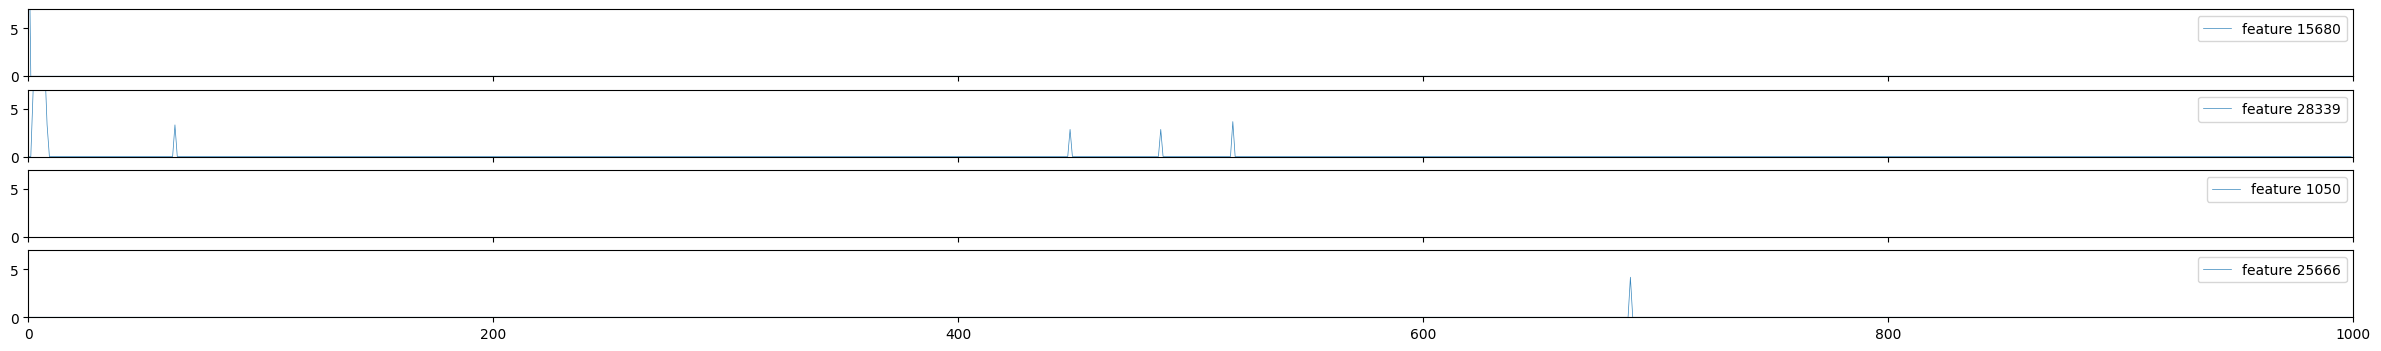

In [8]:
# Next, we plot a few of the features
selected_features = [15680, 28339, 1050, 25666]
fig, axes = plt.subplots(len(selected_features), 1, figsize = (30, 1*len(selected_features)), sharex = True)
for ind, feature in enumerate(selected_features):
    axes[ind].plot(feature_ts[:, feature], lw=0.5, label=f"feature {feature}", alpha = 0.9)
    axes[ind].set_xlim(0, feature_ts.shape[0])
    axes[ind].set_ylim([0, 7]) # just to look nice
    axes[ind].set_yticks([0, 5])
    axes[ind].legend()
plt.show()

## Demo from paper

In [9]:
def find_relevant_gb_annotations(records, window_start, window_size, 
                                valid_features={'CDS', 'gene', 'mobile_element', 'misc_feature', 
                                              'rRNA', 'tRNA', 'ncRNA', 'Regulatory', 'tmRNA'},
                                valid_qualifiers={'gene', 'locus_id', 'product', 'mobile_element_type'}):
    """
    Extract annotations from GenBank records within a specified window.
    
    Args:
        records: List of GenBank records
        window_start: Start position of window (int)
        window_size: Size of window (int)
        valid_features: Set of feature types to include
        valid_qualifiers: Set of qualifiers to extract
    
    Returns:
        List of annotations: [start, end, type, qualifiers_dict]
    """
    window_end = window_start + window_size
    annotations = []
    
    for record in records:
        for feature in record.features:
            # Skip features outside window
            if feature.location.end < window_start or feature.location.start > window_end:
                continue
                
            if feature.type in valid_features:
                # Calculate relative positions within window
                start = max(0, feature.location.start - window_start)
                end = min(window_size, feature.location.end - window_start)
                
                # Extract relevant qualifiers
                qualifiers = {q: feature.qualifiers[q] for q in valid_qualifiers 
                            if q in feature.qualifiers}
                
                annotations.append([start, end, feature.type, qualifiers])
    
    return annotations


def extract_sequence(genbank_file, start, end, strand="forward"):
    """
    Extract sequence from GenBank file at specific coordinates.
    
    Args:
        genbank_file: Path to GenBank file
        start: Start position (1-based indexing)
        end: End position (1-based indexing)
        strand: "forward" or "complement"
    
    Returns:
        Extracted sequence as string
    """
    record = SeqIO.read(genbank_file, "genbank")
    seq = record.seq[start-1:end]  # Convert to 0-based indexing
    
    if strand.lower() == "complement":
        seq = seq.reverse_complement()
        
    return str(seq)

# Annotation colors
ANNOTATION_COLORS = {
    'CDS': 'white',
    'gene': 'gray', 
    'mobile_element': 'green',
    'misc_feature': 'yellow',
    'rRNA': '#7AC8AC',
    'tRNA': '#662D91',
    'ncRNA': 'white',
    'Regulatory': 'red',
    'tmRNA': 'red'
}

In [10]:
# torch.cuda.empty_cache()

In [11]:
# Get features and plot over a 100kb chunk of the E. coli str. K-12 substr. MG1655 genome, recreating part of the main and supplementary figures
# Download from NCBI: https://www.ncbi.nlm.nih.gov/nuccore/556503834
genbank_file_path = './NC_000913.gb'
start_pos = 4130000
end_pos = 4230000
selected_features = [13606, 26069, 30262, 2812, 15680, 11734, 24568, 15481]

# Load GenBank and get features
records = list(SeqIO.parse(genbank_file_path, "genbank"))
sequence = extract_sequence(genbank_file_path, start_pos, end_pos)
annotations = find_relevant_gb_annotations(records, start_pos, end_pos - start_pos)
feature_ts = get_feature_ts(topk_sae, sequence)

# Plot selected features with genbank annotations visualized as well
fig, axes = plt.subplots(len(selected_features), 1,  figsize=(40, len(selected_features)), sharex=True)
for i, feature_id in enumerate(selected_features):
    axes[i].plot(feature_ts[:, feature_id], lw=0.5, label=f"feature {feature_id}", alpha=0.9)
    for start, end, feature_type, _ in annotations:
        axes[i].axvspan(start, end, color=ANNOTATION_COLORS.get(feature_type, 'black'), alpha=0.2)
    axes[i].set_xlim(0, feature_ts.shape[0])
    axes[i].set_yticks([0, 5])
    axes[i].legend()
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 15.41 GiB. GPU 0 has a total capacity of 44.52 GiB of which 7.93 GiB is free. Process 400437 has 36.58 GiB memory in use. Of the allocated memory 26.84 GiB is allocated by PyTorch, and 9.23 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)